In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import timezone
from scipy.signal import find_peaks

plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = "/content/drive/MyDrive/Projects/Ian_SensAI/data/SNL_18650_LFP_15C_0-100_0.5-1C_a_cycle_data.csv"
df = pd.read_csv(path)
df.shape

In [ ]:
df.columns

Index(['Cycle_Index', 'Start_Time', 'End_Time', 'Test_Time (s)',
       'Min_Current (A)', 'Max_Current (A)', 'Min_Voltage (V)',
       'Max_Voltage (V)', 'Charge_Capacity (Ah)', 'Discharge_Capacity (Ah)',
       'Charge_Energy (Wh)', 'Discharge_Energy (Wh)'],
      dtype='object')

In [ ]:
DISCHARGE = 'Discharge_Capacity (Ah)'

In [ ]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])

In [ ]:
df['Start_Time'] = df['Start_Time'].dt.round(freq='T')
df['End_Time'] = df['End_Time'].dt.round(freq='T')

In [ ]:
df.head()

,Cycle_Index,Start_Time,End_Time,Test_Time (s),Min_Current (A),Max_Current (A),Min_Voltage (V),Max_Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh)
0,1.0,2018-02-01 10:02:00,2018-02-01 14:23:00,15645.311,-0.55,0.55,1.998,3.6,1.019,1.030,3.467,3.274
1,2.0,2018-02-01 14:23:00,2018-02-01 18:40:00,31091.752,-0.55,0.55,1.995,3.6,1.037,1.032,3.509,3.281
2,3.0,2018-02-01 18:40:00,2018-02-01 22:57:00,46506.174,-0.55,0.55,1.997,3.6,1.037,1.033,3.510,3.284
3,4.0,2018-02-01 22:57:00,2018-02-02 05:27:00,69871.589,-1.10,0.55,1.995,3.6,2.075,2.065,7.016,6.418
4,5.0,2018-02-02 05:29:00,2018-02-02 08:35:00,81179.918,-1.10,0.55,1.993,3.6,1.037,1.033,3.502,3.210


In [ ]:
df.tail()

,Cycle_Index,Start_Time,End_Time,Test_Time (s),Min_Current (A),Max_Current (A),Min_Voltage (V),Max_Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh)
4545,4547.0,2020-02-15 04:06:00,2020-02-15 06:55:00,4.887246e+07,-1.10,0.549,1.996,3.600,0.950,0.945,3.187,2.966
4546,4548.0,2020-02-15 06:55:00,2020-02-15 10:46:00,4.888637e+07,-0.55,0.549,1.996,3.600,0.950,0.947,3.187,3.024
4547,4549.0,2020-02-15 10:46:00,2020-02-15 14:39:00,4.890035e+07,-0.55,0.549,1.998,3.600,0.952,0.947,3.199,3.024
4548,4550.0,2020-02-15 14:39:00,2020-02-15 18:33:00,4.891434e+07,-0.55,0.549,1.998,3.600,0.953,0.947,3.202,3.025
4549,4551.0,2020-02-15 18:33:00,2020-02-15 18:34:00,4.891440e+07,0.00,0.000,2.641,2.648,0.000,0.000,0.000,0.000


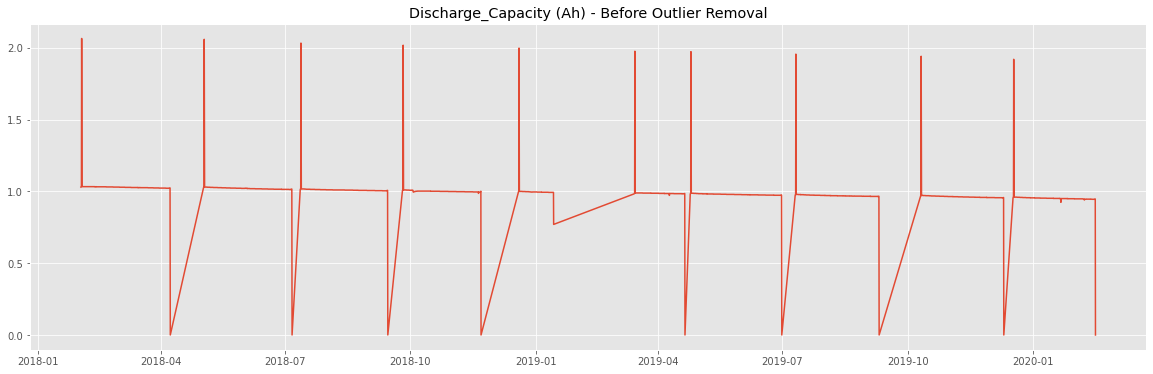

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(df['Start_Time'], df[DISCHARGE])
plt.title(f'{DISCHARGE} - Before Outlier Removal')
plt.show()

for step 1: 
drop the ones above and below the threshold. 
most values should sit between 1.1 and 0.5. 
anything else is unrealistic (another way to do it might be to check the difference between consecutive points, which should be >0.1 or <-0.1). 
but rather than just drop them, replace them with an interpolated value

In [ ]:
df.drop(df.index[-1], inplace=True)
df.tail()

,Cycle_Index,Start_Time,End_Time,Test_Time (s),Min_Current (A),Max_Current (A),Min_Voltage (V),Max_Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh)
4544,4546.0,2020-02-15 01:16:00,2020-02-15 04:04:00,4.886225e+07,-1.10,0.549,1.998,3.6,0.950,0.945,3.187,2.965
4545,4547.0,2020-02-15 04:06:00,2020-02-15 06:55:00,4.887246e+07,-1.10,0.549,1.996,3.6,0.950,0.945,3.187,2.966
4546,4548.0,2020-02-15 06:55:00,2020-02-15 10:46:00,4.888637e+07,-0.55,0.549,1.996,3.6,0.950,0.947,3.187,3.024
4547,4549.0,2020-02-15 10:46:00,2020-02-15 14:39:00,4.890035e+07,-0.55,0.549,1.998,3.6,0.952,0.947,3.199,3.024
4548,4550.0,2020-02-15 14:39:00,2020-02-15 18:33:00,4.891434e+07,-0.55,0.549,1.998,3.6,0.953,0.947,3.202,3.025


In [ ]:
peaks_1 = find_peaks(df[DISCHARGE], threshold=0.1)[0]
q = df[DISCHARGE] * -1
peaks_2 = find_peaks(q, threshold=0.1)[0]

In [ ]:
peaks_idx = np.concatenate((peaks_1,peaks_2))
np.ndarray.sort(peaks_idx)

In [ ]:
df['Discharge_Capacity (Ah)'][peaks_idx]

3       2.065
505     0.000
509     2.059
1011    0.000
1015    2.033
1517    0.000
1521    2.018
1977    0.000
1981    1.998
2184    0.770
2188    1.976
2484    0.000
2488    1.973
3031    0.000
3035    1.956
3537    0.000
3541    1.941
4043    0.000
4047    1.920
Name: Discharge_Capacity (Ah), dtype: float64

In [ ]:
df.loc[peaks_idx, DISCHARGE] = np.nan
df = df.fillna(method = 'ffill')

In [ ]:
df['Discharge_Capacity (Ah)'][peaks_idx]

3       1.033
505     1.024
509     1.030
1011    1.016
1015    1.018
1517    1.007
1521    1.010
1977    1.001
1981    1.000
2184    0.993
2188    0.988
2484    0.985
2488    0.986
3031    0.975
3035    0.978
3537    0.966
3541    0.971
4043    0.957
4047    0.960
Name: Discharge_Capacity (Ah), dtype: float64

In [ ]:
timestamp_df = df.copy()
timestamp_df['Start_Time'] = timestamp_df['Start_Time'].apply(lambda x: x.timestamp())
timestamp_df['End_Time'] = timestamp_df['End_Time'].apply(lambda x: x.timestamp())

In [ ]:
timestamp_df.head(2)

,Cycle_Index,Start_Time,End_Time,Test_Time (s),Min_Current (A),Max_Current (A),Min_Voltage (V),Max_Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh)
0,1.0,1.517479e+09,1.517495e+09,15645.311,-0.55,0.55,1.998,3.6,1.019,1.030,3.467,3.274
1,2.0,1.517495e+09,1.517510e+09,31091.752,-0.55,0.55,1.995,3.6,1.037,1.032,3.509,3.281


In [ ]:
timestamp_df.tail(2)

,Cycle_Index,Start_Time,End_Time,Test_Time (s),Min_Current (A),Max_Current (A),Min_Voltage (V),Max_Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh)
4547,4549.0,1.581764e+09,1.581778e+09,4.890035e+07,-0.55,0.549,1.998,3.6,0.952,0.947,3.199,3.024
4548,4550.0,1.581778e+09,1.581792e+09,4.891434e+07,-0.55,0.549,1.998,3.6,0.953,0.947,3.202,3.025


In [ ]:
first_start_time = timestamp_df['Start_Time'].iloc[0]
last_end_time = timestamp_df['End_Time'].iloc[-1]+10

first_start_time, last_end_time

In [ ]:
devided_values = np.arange(first_start_time ,last_end_time, 10)

In [ ]:
a_dataframe = pd.DataFrame(devided_values, columns= ['Time'])

In [ ]:
final_df = pd.merge(a_dataframe, timestamp_df[['Start_Time', DISCHARGE]], how='left', left_on='Time', right_on='Start_Time')

In [ ]:
final_df[~final_df['Start_Time'].isna()].head(10)

,Time,Start_Time,Discharge_Capacity (Ah)
0,1.517479e+09,1.517479e+09,1.030
1566,1.517495e+09,1.517495e+09,1.032
3108,1.517510e+09,1.517510e+09,1.033
4650,1.517526e+09,1.517526e+09,1.033
7002,1.517549e+09,1.517549e+09,1.033
8130,1.517561e+09,1.517561e+09,1.033
9258,1.517572e+09,1.517572e+09,1.033
10386,1.517583e+09,1.517583e+09,1.033
11514,1.517594e+09,1.517594e+09,1.033
12642,1.517606e+09,1.517606e+09,1.033


In [ ]:
final_df.head()

,Time,Start_Time,Discharge_Capacity (Ah)
0,1.517479e+09,1.517479e+09,1.03
1,1.517479e+09,NaN,NaN
2,1.517479e+09,NaN,NaN
3,1.517479e+09,NaN,NaN
4,1.517479e+09,NaN,NaN


In [ ]:
x = (timestamp_df['Start_Time'].to_numpy()).astype(float)
y = (timestamp_df['Discharge_Capacity (Ah)'].to_numpy()).astype(float)

In [ ]:
result = np.interp(devided_values, x, y)

In [ ]:
final_df[DISCHARGE] = result

In [ ]:
final_df.head(10)

,Time,Start_Time,Discharge_Capacity (Ah)
0,1.517479e+09,1.517479e+09,1.030000
1,1.517479e+09,NaN,1.030001
2,1.517479e+09,NaN,1.030003
3,1.517479e+09,NaN,1.030004
4,1.517479e+09,NaN,1.030005
5,1.517479e+09,NaN,1.030006
6,1.517479e+09,NaN,1.030008
7,1.517479e+09,NaN,1.030009
8,1.517479e+09,NaN,1.030010
9,1.517479e+09,NaN,1.030011


In [ ]:
final_df.tail(10)

,Time,Start_Time,Discharge_Capacity (Ah)
6431217,1.581791e+09,NaN,0.947
6431218,1.581792e+09,NaN,0.947
6431219,1.581792e+09,NaN,0.947
6431220,1.581792e+09,NaN,0.947
6431221,1.581792e+09,NaN,0.947
6431222,1.581792e+09,NaN,0.947
6431223,1.581792e+09,NaN,0.947
6431224,1.581792e+09,NaN,0.947
6431225,1.581792e+09,NaN,0.947
6431226,1.581792e+09,NaN,0.947


In [ ]:
final_df.drop(columns=['Start_Time'], inplace=True)

In [ ]:
final_df['Time'] = pd.to_datetime(final_df['Time'], unit='s')

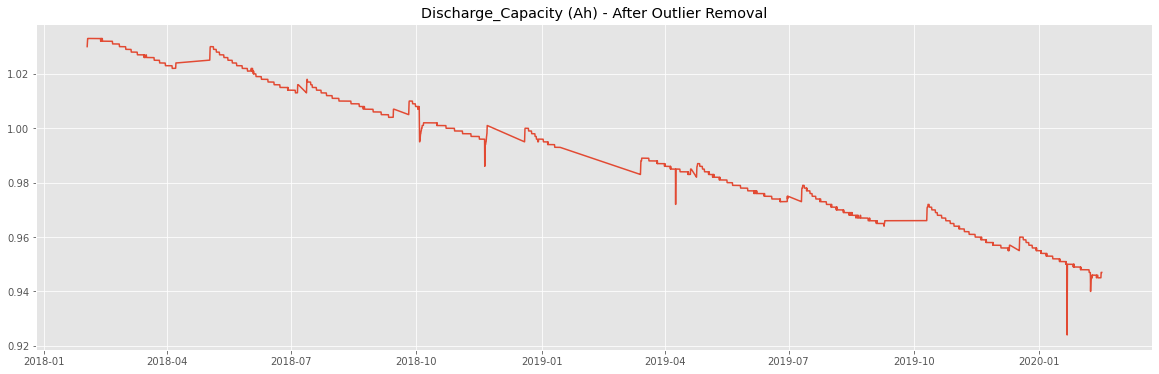

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(final_df['Time'], final_df[DISCHARGE])
plt.title(f'{DISCHARGE} - After Outlier Removal')
plt.show()

In [ ]:
final_df.head()

,Time,Discharge_Capacity (Ah)
0,2018-02-01 10:02:00,1.030000
1,2018-02-01 10:02:10,1.030001
2,2018-02-01 10:02:20,1.030003
3,2018-02-01 10:02:30,1.030004
4,2018-02-01 10:02:40,1.030005


In [ ]:
final_df.to_csv('SNL_18650_LFP_15C_0-100_0.5-1C_a_cycle_data_wo_outlier_10s_sampled.csv', index=False)

In [ ]:
! zip SNL_18650_LFP_15C_0-100_0.5-1C_a_cycle_data_wo_outlier_10s_sampled.zip SNL_18650_LFP_15C_0-100_0.5-1C_a_cycle_data_wo_outlier_10s_sampled.csv

  adding: SNL_18650_LFP_15C_0-100_0.5-1C_a_cycle_data_wo_outlier_10s_sampled.csv (deflated 87%)


In [ ]:
! cp SNL_18650_LFP_15C_0-100_0.5-1C_a_cycle_data_wo_outlier_10s_sampled.zip /content/drive/MyDrive/Projects/Ian_SensAI/data/